In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

c:\Users\matve\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Early Stopping Implementation

In [2]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after certain epochs.

    Args:
        model_path (str): Path to save the best model.
        patience (int): How long to wait after last time validation loss improved. Default: 10.
        verbose (bool): If true print a message if early stopping triggered. Default: False.

    Attributes:
        counter (int): Counter for how many epochs have passed since the last validation loss improvement.
        best_loss (float): Best validation loss observed.
        early_stop (bool): Whether early stopping is triggered.
    """
    def __init__(self, model_path: str, patience: int=10, verbose: bool=False):
        self.patience = patience
        self.verbose = verbose
        self.path = model_path
        
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float, model: nn.Module):
        """
        Call method to check if early stopping condition is met.

        Args:
            val_loss (float): Current validation loss.
            model (torch.nn.Module): Model to save if validation loss improves.
        """
        
        if self.early_stop:
            return

        assert (
            hasattr(model, 'save_model') and callable(getattr(model, 'save_model'))
        ), "Model must have a save_model method."

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            model.save_model(self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

Here Early Stopping class without saving model

In [3]:
class EarlyStopping_WithoutSaving:
    """
    Early stopping to stop the training when the loss does not improve after certain epochs.

    Args:
        patience (int): How long to wait after last time validation loss improved. Default: 10.
        verbose (bool): If true print a message if early stopping triggered. Default: False.

    Attributes:
        counter (int): Counter for how many epochs have passed since the last validation loss improvement.
        best_loss (float): Best validation loss observed.
        early_stop (bool): Whether early stopping is triggered.
    """
    def __init__(self, patience: int=10, verbose: bool=False):
        self.patience = patience
        self.verbose = verbose
        
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float):
        """
        Call method to check if early stopping condition is met.

        Args:
            val_loss (float): Current validation loss.
        """
        
        if self.early_stop:
            return
        
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

# Neural Network Baseline

In [4]:
class LinearNeuralNetworkBaseline(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: list[int], output_dim: int, model_path: str, patience: int):
        """
        Initializes a linear neural network baseline model with early stopping.

        Args:
            input_dim (int): The dimension of the input features.
            hidden_dims (list[int]): A list of integers defining the number of neurons in each hidden layer.
            output_dim (int): The number of output classes.
            model_path (str): Path where the best model will be saved.
            patience (int): The number of epochs to wait after no improvement before triggering early stopping.
        """
        super(LinearNeuralNetworkBaseline, self).__init__()
        
        assert len(hidden_dims) > 0, "hidden_dims must have at least one element"
        
        self.linear_layers = nn.ModuleList()
        self.early_stopping = EarlyStopping(model_path=model_path, patience=patience, verbose=True)
        
        for layer_dim in hidden_dims:
            self.linear_layers.append(nn.Linear(input_dim, layer_dim))
            self.linear_layers.append(nn.BatchNorm1d(layer_dim))
            self.linear_layers.append(nn.ReLU())
            self.linear_layers.append(nn.Dropout(0.5))
            
            input_dim = layer_dim
        
        self.linear_layers.append(nn.Linear(input_dim, output_dim))
        
        self.train_loss_history = []
        self.valid_loss_history = []
        
        
    def forward(self, x):
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x
    
    
    def fit(self, train_loader: DataLoader, valid_loader: DataLoader, nepochs: int = 10,
            device: torch.device = torch.device('cuda'), lr: float = 1e-2) -> None:
        """
        Trains the model using the provided training and validation data loaders.

        Args:
            train_loader (DataLoader): DataLoader for training data.
            valid_loader (DataLoader): DataLoader for validation data.
            nepochs (int, optional): Number of epochs for training. Defaults to 10.
            device (torch.device, optional): Device to run training on. Defaults to CUDA.
            lr (float, optional): Learning rate for the optimizer. Defaults to 1e-2.
        """
        # Define optimizer and learning rate scheduler
        self.optim = torch.optim.Adam(self.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', factor=0.5, patience=3)
        
        self.train().to(device)
        criterion = nn.CrossEntropyLoss()
        
        for ep in tqdm(range(nepochs), desc='Epoch'):
            for data, label in train_loader:
                self.optim.zero_grad()

                data, label = data.to(device), label.to(device)
                output = self.forward(data)
                
                loss = criterion(output, label)

                loss.backward()
                self.optim.step()

            self.train_loss_history.append(self.calc_loss(train_loader, device=device).mean())
            self.valid_loss_history.append(self.calc_loss(valid_loader, device=device).mean())

            print_loss_bool = (ep + 1) % 10 == 0 if nepochs > 10 else True
            if print_loss_bool:
                print(f'Train loss: {self.train_loss_history[-1]:.10f}')
                print(f'Valid loss: {self.valid_loss_history[-1]:.10f}')
                print(f'Learning rate: {self.optim.param_groups[0]["lr"]:.10f}\n')

            self.scheduler.step(self.valid_loss_history[-1])
            
            # self.early_stopping(self.valid_loss_history[-1]) without saving
            self.early_stopping(self.valid_loss_history[-1], self)

            if self.early_stopping.early_stop:
                break
            
    def predict(self, data_loader: DataLoader, device: torch.device = torch.device('cuda')) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Generates predictions for the given data loader.

        Args:
            data_loader (DataLoader): DataLoader containing the data for prediction.
            device (torch.device, optional): Device to perform prediction on. Defaults to CUDA.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the predicted labels and the ground truth labels.
        """
        self.eval().to(device)
        all_preds: list[torch.Tensor] = []
        all_labels: list[torch.Tensor] = []
        
        with torch.no_grad():
            for data, labels in data_loader:
                data = data.to(device)
        
                output = self.forward(data)
                preds = torch.argmax(output, dim=1)
        
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())
        
        return torch.cat(all_preds), torch.cat(all_labels)
            
            
    def calc_loss(self, data_loader: DataLoader, device: torch.device) -> torch.Tensor:
        """
        Calculates the loss over the entire dataset provided by the data loader.

        Args:
            data_loader (DataLoader): DataLoader for the data to compute loss.
            device (torch.device): Device on which computation will be performed.

        Returns:
            torch.Tensor: Concatenated tensor of losses for each batch.
        """
        self.eval().to(device)
        criterion = nn.CrossEntropyLoss(reduction='none')
        
        losses: list[torch.Tensor] = []
        with torch.no_grad():
            for data, label in data_loader:
                data, label = data.to(device), label.to(device)
                output = self.forward(data)
                batch_loss = criterion(output, label)
                losses.append(batch_loss.cpu())
                
        return torch.cat(losses)
    
    
    def save_model(self, path: str) -> None:
        """
        Saves the model state and training history to the specified path.

        Args:
            path (str): The file path where the checkpoint will be saved.
        """
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'train_loss_history': self.train_loss_history,
            'valid_loss_history': self.valid_loss_history,
        }
        torch.save(checkpoint, path)


    def load_model(self, path: str) -> None:
        """
        Loads the model state and training history from the specified checkpoint file.

        Args:
            path (str): The file path of the checkpoint.
        """
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.train_loss_history = checkpoint['train_loss_history']
        self.valid_loss_history = checkpoint['valid_loss_history']
        
        
    def plot_loss(self) -> None:
        """
        Plots the training and validation loss curves over epochs.
        """
        loss_values_train = [loss.item() for loss in self.train_loss_history]
        loss_values_val = [loss.item() for loss in self.valid_loss_history]

        plt.figure(figsize=(12, 8))
        plt.plot(loss_values_train, marker='o', linestyle='-', color='b', label='Training Loss')
        plt.plot(loss_values_val, marker='o', linestyle='-', color='r', label='Validation Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Example of usage

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import numpy as np

In [6]:
# Create a synthetic classification dataset using sklearn
X, y = make_classification(
    n_samples=1000, 
    n_features=20, 
    n_informative=15, 
    n_redundant=5, 
    n_classes=3, 
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders for training and validation
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [8]:
# Model parameters
input_dim = X_train.shape[1]   # 20 features
hidden_dims = [32, 16]         # Two hidden layers with 32 and 16 neurons respectively
output_dim = len(np.unique(y)) # Number of classes (3)
model_path = "best_model.pth"
patience = 3

In [9]:
model = LinearNeuralNetworkBaseline(input_dim, hidden_dims, output_dim, model_path, patience)

In [10]:
model.fit(train_loader, val_loader, nepochs=20, device=device, lr=1e-3)

Epoch:  55%|█████▌    | 11/20 [00:01<00:01,  8.79it/s]

Train loss: 0.5388707519
Valid loss: 0.7097125649
Learning rate: 0.0010000000



Epoch: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]

Train loss: 0.3267178535
Valid loss: 0.6075150967
Learning rate: 0.0010000000



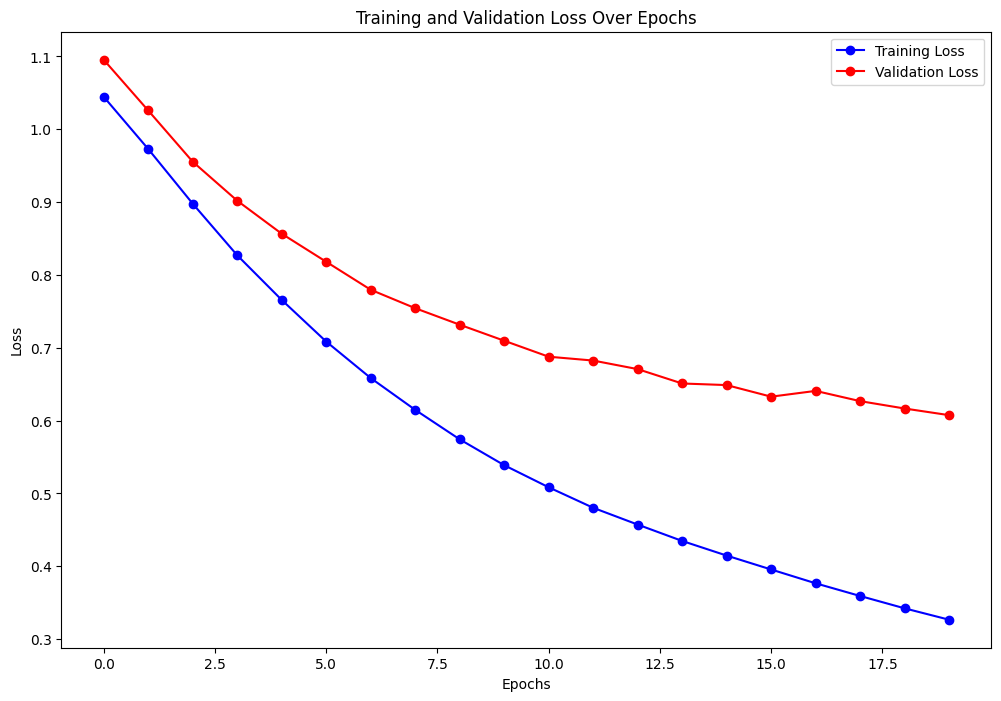

In [11]:
model.plot_loss()

In [12]:
model.save_model(model_path)
print("Model saved.")

Model saved.


In [13]:
model.load_model(model_path)
print("Model loaded.")

Model loaded.


In [14]:
preds, labels = model.predict(test_loader, device=device)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.82      0.82      0.82       114
           2       0.73      0.74      0.73        87

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



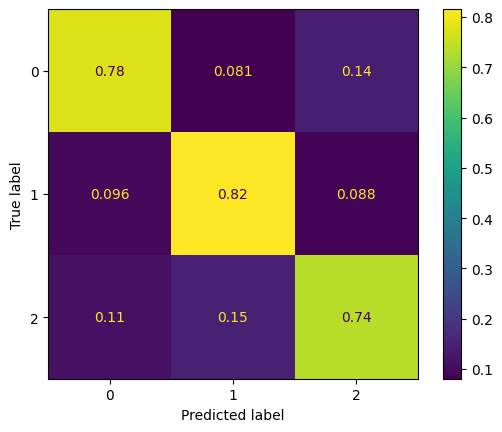

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report:")
print(classification_report(labels, preds))

cm = confusion_matrix(labels, preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()